<a href="https://colab.research.google.com/github/EdisonVazquezG/KnotNet_invariants/blob/main/Knot_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Invariants from latent representations

# Packages

In [90]:
from google.colab import drive
import sys
drive.mount('/content/drive/')
my_path = "/Colab Notebooks/" # Your path
gdrive_path = "/content/drive" + "/My Drive" + my_path
sys.path.append(gdrive_path)


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [91]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
import torch.optim as optim
from tensorflow.keras.callbacks import EarlyStopping
import umap
import copy
import matplotlib.pyplot as plt
import torch.nn as nn

import knot_utils
import knot_ml_models
import knot_visualizer

import importlib
importlib.reload(knot_utils)
importlib.reload(knot_ml_models)
importlib.reload(knot_visualizer)

from knot_utils import scale_data,preprocess,sampling,drop_,split_data
from knot_ml_models import build_autoencoder,MLP_single,MLP_combined,train_model,evaluate_model
from knot_visualizer import ErrorVisualizer, UMAPVisualizer, PCAVisualizer, SIGNATURE_COLORS


# **1 |** Data
Our dataset consists of 313,231 knots, each represented by three polynomial invariants: the Alexander polynomial (17 coefficients), the Jones polynomial (51 coefficients), and the HOMFLY-PT polynomial (152 coefficients). In addition to these invariants, we also have access to knot-level topological descriptors such as signature, number of crossings, and alternation class.


In [34]:
A = pd.read_csv(gdrive_path + "alexander_15.csv")
J = pd.read_csv(gdrive_path  + "Jones_upto_15_MIRRORS.csv")
H = pd.read_csv(gdrive_path + "hompfly.csv")
signature = A[['signature']]
H_with_signature = copy.deepcopy(H)
H_with_signature['signature'] = signature
## This will work for just keep certain variables that will help in the posterior analysis
J_15 = J[~J['knot_id'].str.contains('!')]
H_15 = H.merge(A[['signature']],left_on=H.index,right_on=A.index)

## **1.1 |** Preprocess
In this part, we keep the coefficients and eliminate the variables related to the knots.

In [16]:
alexander_p, jones_p, H_p= preprocess(J,A,H,True)
a_f = alexander_p.drop(columns=["Unnamed: 0"]) ## Must be in the preprocess section
a_f = a_f.reset_index(drop=True)
j_f = jones_p.reset_index(drop=True)
H_f = H_p.reset_index(drop=True)

# **2 |** Data Set Considerations
We will work with three distinct data sets to support our analysis:

1. ***Complete Knots:***
This data set includes all available knot data, encompassing both standard and hard knots (**These correspond to the data set described in Subsection 1.1**).

2. ***Cleaned Knots (Excluding Hard Knots):***
A refined version of the full data set, this excludes hard knots to focus on more typical cases.

3. ***Sampled Subset:***
If we want to take only a sample of the knots with certain characteristics at the *signature level*

*Note:*
Regardless of the data set used, each must undergo a scaling process before further analysis.

## 2.2 ***Cleaned Knots (Excluding Hard Knots)***

In [5]:
A_cleaned =  drop_(A,145200) ## This will not scaled their coefficients for future analysis
a_c = drop_(a_f,145200)
j_c = drop_(j_f,145200)
H_c = drop_(H_f,145200)
signature_c = A_cleaned[['signature']]

## 2.3 | ***Sampled Subset***

Should be define the target_signatures and the n samples


In [13]:
target_signatures = [0, 2, 4, 6, 8]
n = 6135
A_s = sampling(A,n,target_signatures)
J_s = sampling(J,n,target_signatures)
H_s = sampling(H_with_signature,n,target_signatures)
alexander_s, jones_s, H_s= preprocess(J_s,A_s,H_s,True)
a_s = alexander_s.drop(columns=["Unnamed: 0"]) ## Must be in the preprocess section
a_s = a_s.reset_index(drop=True)
j_s = jones_s.reset_index(drop=True)
H_s = H_s.reset_index(drop=True)

## **2.3 |** Scaling

So, which data set are you planning to go with?

In [25]:
# Interactive selection
DataSet = "Cleaned Knots" # @param {type:"string"}

# Mapping for each dataset
dataset_map = {
    "Complete Knots": {"alexander": a_f, "jones": j_f, "Homfly": H_f},
    "Cleaned Knots": {"alexander": a_c, "jones": j_c, "Homfly": H_c},
    "Sampled Subset": {"alexander": a_s, "jones": j_s, "Homfly": H_s},
}
# Get the corresponding variables
selected = dataset_map.get(DataSet)

# Apply scaling
alexander_, alex_scaler = scale_data(selected["alexander"])
jones_, jones_scaler = scale_data(selected["jones"])
H_, H_scaler = scale_data(selected["Homfly"])

#A_J = pd.concat([alexander,jones],axis=1)
print(jones_.shape)
print(alexander_.shape)
print(H_.shape)

# **2 |** Latent Representation


## **2.1 |** Settings

In [33]:
latent_space_J = 25
latent_space_A = 9
latent_space_H = 75

## Reduction filter
v_n_j = [128,64,64]
v_n_a = [64,32,32]
v_n_h = [256,128,128]

autoencoder_J, encoder_J = build_autoencoder(jones_.shape[1],latent_space_J, v_n_j)
autoencoder_A, encoder_A = build_autoencoder(alexander_.shape[1],latent_space_A,v_n_a)
autoencoder_H, encoder_H = build_autoencoder(H_.shape[1],latent_space_H,v_n_h)

early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
epochs=30
batch_size=128

## **2.2 |** Training

In [9]:
autoencoder_J.fit(jones_,jones_,epochs=epochs,batch_size=batch_size,shuffle=True, callbacks=[early_stop])
autoencoder_A.fit(alexander_,alexander_,epochs=epochs,batch_size=batch_size,shuffle=True, callbacks=[early_stop])
autoencoder_H.fit(H_,H_,epochs=epochs,batch_size=batch_size,shuffle=True, callbacks=[early_stop])

Epoch 1/30
2448/2448 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.6739
Epoch 2/30
2448/2448 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1211
Epoch 3/30
2448/2448 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0876
Epoch 4/30
2448/2448 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0630
Epoch 5/30
2448/2448 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0570
Epoch 6/30
2448/2448 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0599
Epoch 7/30
2448/2448 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0436
Epoch 8/30
2448/2448 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0357
Epoch 9/30
2448/2448 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0337
Epoch 10/30
2448/2448 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0334
Epoch 11/30
2448/2448 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0238
Epoch 12/30
2448/2448 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0237
Epoch 13/30
2448/2448 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0193
Epoch 14/30
2448/2448 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0216
Epoch 15/30
2448/2448 ━━━━━━

## **2.3 |** Evaluation

In [27]:
# Reconstructing the predictions.
reconstructed_J = autoencoder_J.predict(jones_)
reconstructed_A = autoencoder_A.predict(alexander_)
reconstructed_H = autoencoder_H.predict(H_)

9789/9789 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
9789/9789 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
9789/9789 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U14'), dtype('float64')) -> None

### **2.3.1 |** MSE per sample for the invariants

In [31]:
# MSE per sample
mse_per_sample_J = np.mean((jones_ - reconstructed_J)**2, axis=1)
mse_per_sample_A = np.mean((alexander_ - reconstructed_A)**2, axis=1)
mse_per_sample_H = np.mean((H_ - reconstructed_H)**2, axis=1)

# Imprimimos algunas estadísticas rápidas
print(f"Mean MSE per sample for Jones: {np.mean(mse_per_sample_J):.6f}")
print(f"Max MSE per sample for Jones: {np.max(mse_per_sample_J):.6f}")
print(f"Min MSE per sample for Jones: {np.min(mse_per_sample_J):.6f}")
print("------------------------------------------------------------------------------")
print(f"Mean MSE per sample for Alexander: {np.mean(mse_per_sample_A):.6f}")
print(f"Max MSE per sample for Alexander: {np.max(mse_per_sample_A):.6f}")
print(f"Min MSE per sample for Alexander: {np.min(mse_per_sample_A):.6f}")
print("------------------------------------------------------------------------------")
print(f"Mean MSE per sample for Homfly: {np.mean(mse_per_sample_H):.6f}")
print(f"Max MSE per sample for Homfly: {np.max(mse_per_sample_H):.6f}")
print(f"Min MSE per samplefor H: {np.min(mse_per_sample_H):.6f}")


Mean MSE per sample for Jones: 0.019628
Max MSE per sample for Jones: 196.525955
Min MSE per sample for Jones: 0.000130
------------------------------------------------------------------------------
Mean MSE per sample for Alexander: 0.001353
Max MSE per sample for Alexander: 3.224881
Min MSE per sample for Alexander: 0.000054
------------------------------------------------------------------------------
Mean MSE per sample for Homfly: 0.011962
Max MSE per sample for Homfly: 179.766138
Min MSE per samplefor H: 0.000486


### **2.3.2 |** Top n - MSE per sample for the invariants

In [38]:
# Number of knots to inspect
top_n = 3

# Add MSE and signature to each DataFrame
a_c['mse_per_sample'] = mse_per_sample_A
j_c['mse_per_sample'] = mse_per_sample_J
H_c['mse_per_sample'] = mse_per_sample_H

a_c['signature'] = signature_c
j_c['signature'] = signature_c
H_c['signature'] = signature_c

# Sort and select top N with index
top_A = a_c[['mse_per_sample', 'signature']].sort_values(by='mse_per_sample', ascending=False).head(top_n).reset_index()
top_J = j_c[['mse_per_sample', 'signature']].sort_values(by='mse_per_sample', ascending=False).head(top_n).reset_index()
top_H = H_c[['mse_per_sample', 'signature']].sort_values(by='mse_per_sample', ascending=False).head(top_n).reset_index()

# Display tables
print(f"Top {top_n} knots with highest reconstruction error (Alexander):")
print(top_A.to_string(index=False))

print(f"\nTop {top_n} knots with highest reconstruction error (Jones):")
print(top_J.to_string(index=False))

print(f"\nTop {top_n} knots with highest reconstruction error (Homfly):")
print(top_H.to_string(index=False))


Top 3 knots with highest reconstruction error (Alexander):
 index  mse_per_sample  signature
142109        3.224881         12
142115        3.224881         12
145011        3.208767         12

Top 3 knots with highest reconstruction error (Jones):
 index  mse_per_sample  signature
138657      196.525955         12
145177      190.641017         12
145107      186.485042         12

Top 3 knots with highest reconstruction error (Homfly):
 index  mse_per_sample  signature
145195      179.766138         12
118574      126.231823         12
141357      126.231823         12


## **2.4 |** Extract Latent Vectors

In [32]:
latent_vectors_A = encoder_A.predict(alexander_, batch_size=1024)
latent_vectors_J = encoder_J.predict(jones_, batch_size=1024)
latent_vectors_H = encoder_H.predict(H_, batch_size=1024)

306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


#**3 |** Predicting Homfly-PT

## **3.1 |** Model setup

We will define two types of Multi-Layer Perceptron (MLP) models for predicting the HOMFLY-PT polynomial:

1. ***Single-Invariant MLP:***
An MLP model that uses a single knot invariant as input to predict the HOMFLY-PT polynomial.

2. ***Dual-Invariant MLP:***
An MLP model that takes two concatenated invariants as input, providing a richer representation for predicting the HOMFLY-PT polynomial.

In [60]:
# Interactive selection
type_of_model = "Dual-Invariant MLP" # @param {type:"string"}

# Mapping for each dataset
model_map = {
    "Single-Invariant MLP": MLP_single,
    "Dual-Invariant MLP": MLP_combined,
}

# Get the corresponding variables
selected = model_map.get(type_of_model)

print(selected)

<class 'knot_ml_models.MLP_combined'>


## **3.2 |** Data Splitting: Preparing Training and Test Sets

In [92]:
X_data = np.concatenate([latent_vectors_A, latent_vectors_J], axis=1)
train_loader, test_loader, X_test,y_test,sig_train,sig_test = split_data(X_data, latent_vectors_H,signature_c)

## **3.3 |** Training

In [62]:
model = selected(X_data.shape[1], latent_vectors_H.shape[1])
device='cuda' if torch.cuda.is_available() else 'cpu'
trained_model = train_model(
    model, train_loader, test_loader,
    n_epochs=100, lr=1e-3, patience=10, device=device
)

Epoch 1/100 | Train Loss: 0.127745 | Test Loss: 0.110497
Epoch 2/100 | Train Loss: 0.103966 | Test Loss: 0.099456
Epoch 3/100 | Train Loss: 0.097174 | Test Loss: 0.093431
Epoch 4/100 | Train Loss: 0.093072 | Test Loss: 0.091516
Epoch 5/100 | Train Loss: 0.090299 | Test Loss: 0.088772
Epoch 6/100 | Train Loss: 0.088055 | Test Loss: 0.087697
Epoch 7/100 | Train Loss: 0.086256 | Test Loss: 0.085166
Epoch 8/100 | Train Loss: 0.084722 | Test Loss: 0.083863
Epoch 9/100 | Train Loss: 0.083492 | Test Loss: 0.082342
Epoch 10/100 | Train Loss: 0.082221 | Test Loss: 0.080894
Epoch 11/100 | Train Loss: 0.081249 | Test Loss: 0.083390
Epoch 12/100 | Train Loss: 0.080312 | Test Loss: 0.081270
Epoch 13/100 | Train Loss: 0.079722 | Test Loss: 0.079478
Epoch 14/100 | Train Loss: 0.078869 | Test Loss: 0.078697
Epoch 15/100 | Train Loss: 0.078296 | Test Loss: 0.078625
Epoch 16/100 | Train Loss: 0.077522 | Test Loss: 0.077947
Epoch 17/100 | Train Loss: 0.076900 | Test Loss: 0.079034
Epoch 18/100 | Train Lo

## **3.4 |** Evaluation

In [68]:
criterion = nn.MSELoss()
final_mse,preds,targets = evaluate_model(trained_model,test_loader,criterion,device=device)


✅ Final Test MSE: 0.066655


In [69]:
torch.save(trained_model.state_dict(),"/content/drive/MyDrive/Colab Notebooks/mlp_concatenatedAJ_best.pt")

# **4 |** Visualization

In [72]:
colors = SIGNATURE_COLORS.copy()
errors = ((preds - y_test)**2).mean(dim=1).cpu().numpy()
signatures_array = A_cleaned['signature'].values

## 4.1 | Error and violin plots

In [93]:
error_viz = ErrorVisualizer(errors=errors,signatures=sig_test,color_map = colors)

/content/drive/My Drive/Colab Notebooks/knot_visualizer.py:84: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  self.signatures = signatures.squeeze().ravel()


/content/drive/My Drive/Colab Notebooks/knot_visualizer.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Signature', y='Error MSE', data=df_plot,
/content/drive/My Drive/Colab Notebooks/knot_visualizer.py:122: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Signature', y='Error MSE', data=df_plot,
/content/drive/My Drive/Colab Notebooks/knot_visualizer.py:125: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x='Signature', y='Error MSE', data=df_plot,
/content/drive/My Drive/Colab Notebooks/knot_visualizer.py:125: FutureWarning: 

The `errwidth

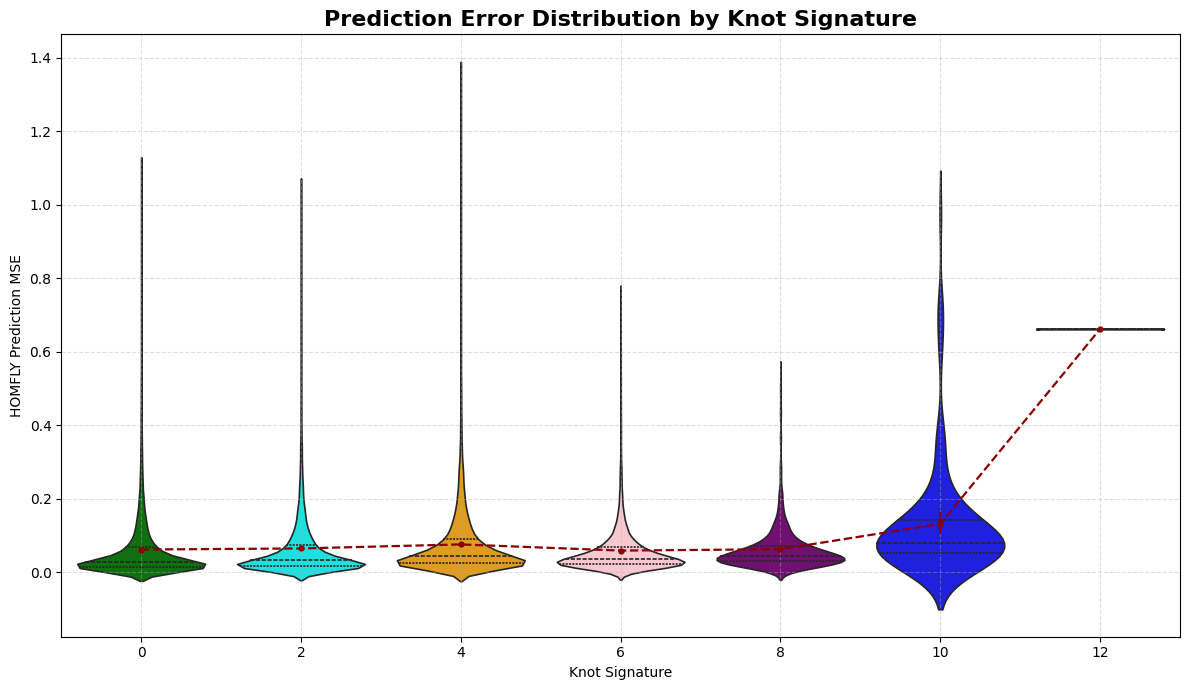

In [94]:
error_viz.plot_violin()

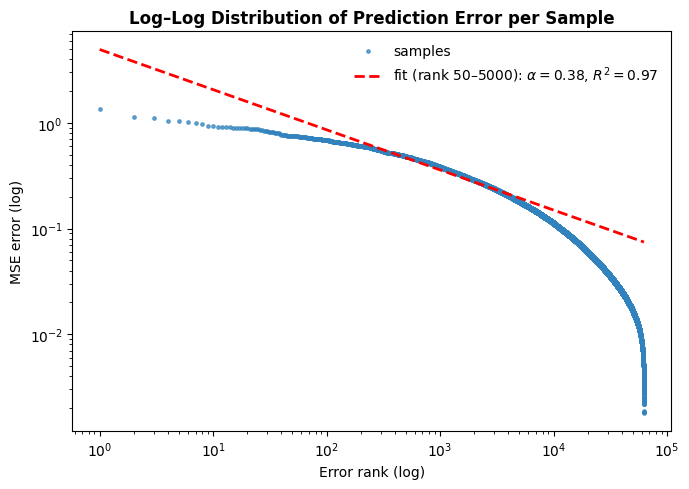

In [95]:
error_viz.plot_loglog_error()

## 4.2 | UMAP and PCA plots

In [96]:
pca_viz = PCAVisualizer(latent_vectors_A,signatures_array,colors)

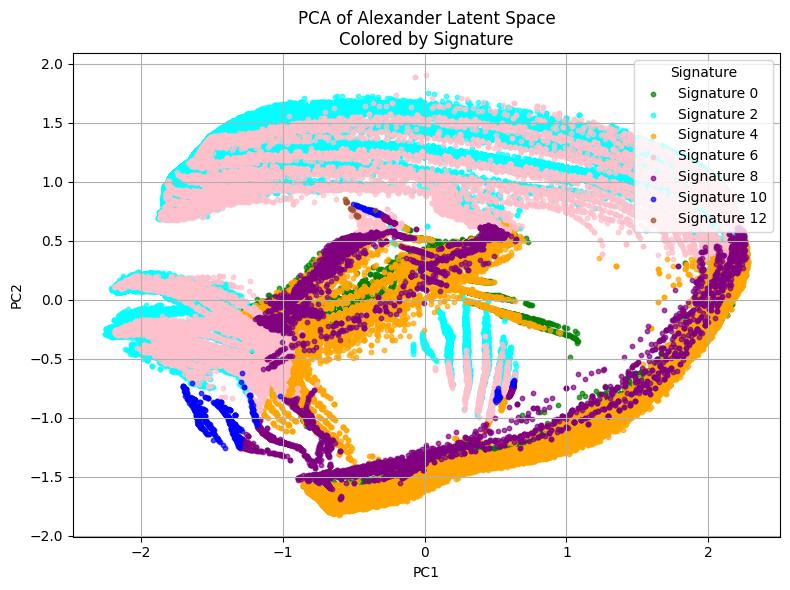

In [97]:
pca_viz.plot(title_prefix="Alexander Latent")

In [99]:
umap_viz = UMAPVisualizer(latent_vectors_A,signatures_array,mse_per_sample=mse_per_sample_A,color_map=colors)

Streaming output truncated to the last 5000 lines.
Falling back to random initialisation!
  warn(
/usr/local/lib/python3.11/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/usr/local/lib/python3.11/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/usr/local/lib/python3.11/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/usr/local/lib/python3.11/dist-packages/umap/spectral.py

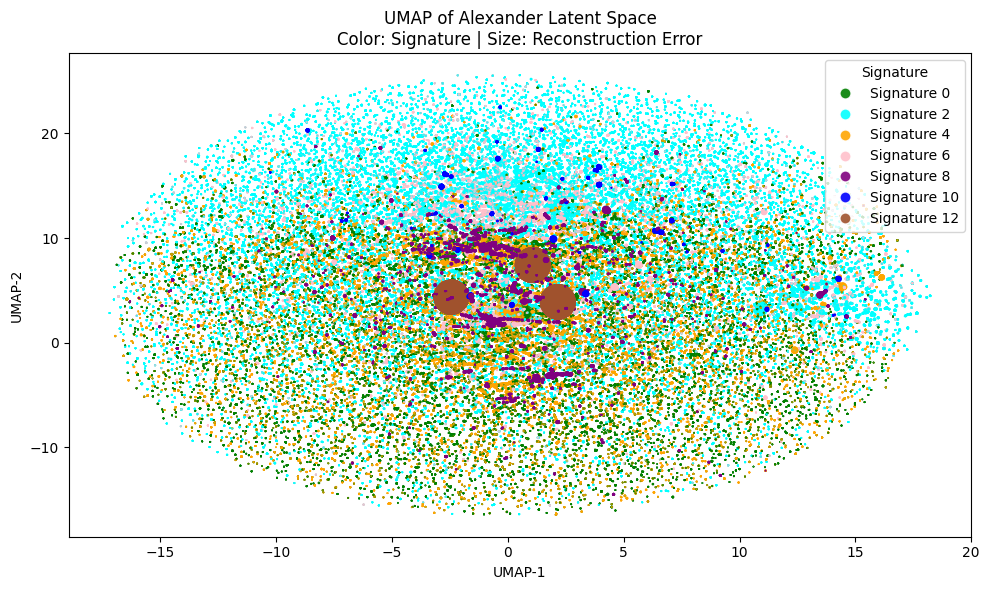

In [100]:
umap_viz.plot(title_prefix="Alexander Latent")